
Sector Reaction (%) on RBI Repo Rate Days (Event Day Only, Sorted by Average Reaction)
                      NIFTY METAL  NIFTY PRIVATE BANK  NIFTY BANK  NIFTY PSU BANK  NIFTY FINANCIAL SERVICES  NIFTY 50  NIFTY CONSUMER DURABLES  NIFTY REALTY  NIFTY FMCG  NIFTY AUTO  NIFTY PHARMA  NIFTY IT  NIFTY CHEMICALS  NIFTY MEDIA
2020-02-06                   0.88                0.96        0.97            2.83                      0.96      0.40                    -0.70         -0.05       -0.64        0.13          1.26     -0.47             0.00         1.57
2020-03-27                   0.77                1.72        1.81            0.34                      0.57      0.22                     0.69         -0.40        0.24       -2.42          0.56      0.27             0.72        -1.13
2020-05-22                  -1.86               -2.85       -2.57           -0.86                     -3.06     -0.74                    -0.80         -1.18       -0.36        0.30          0.84      1.43   

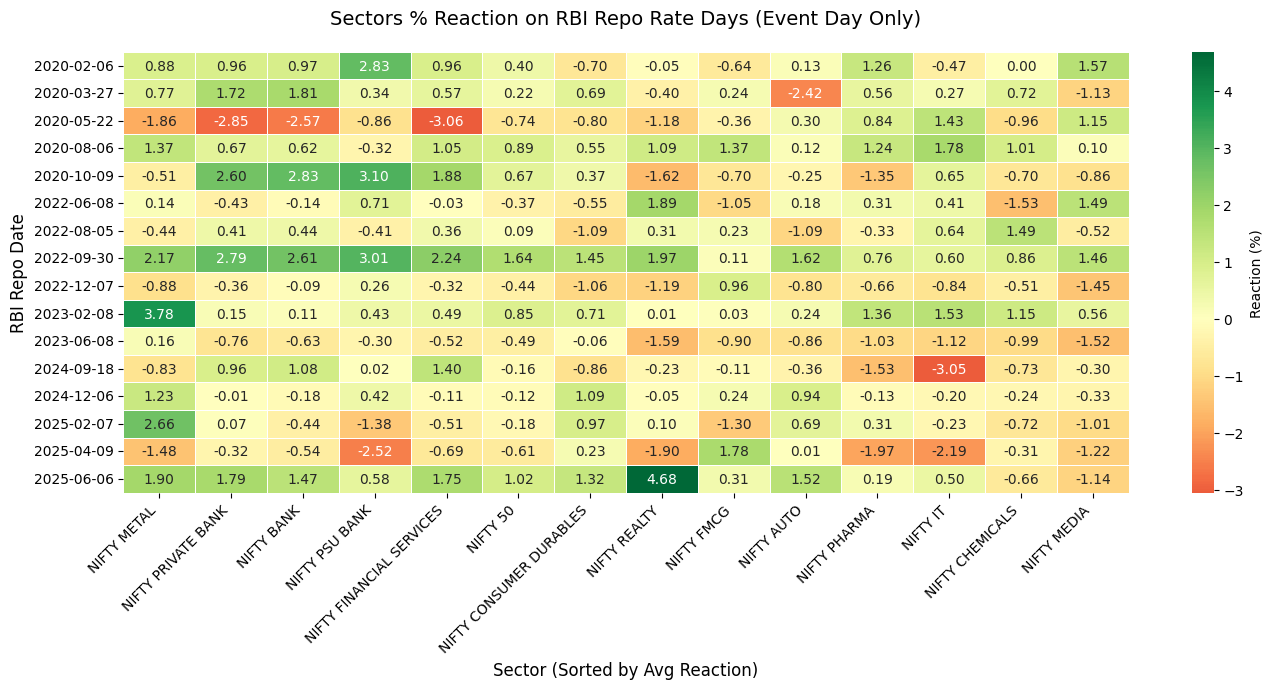

In [1]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Folder Path ---
DATA_FOLDER = r"C:\Users\sohan\Downloads\archive (1)"  # update if needed

# --- Load all sector CSVs ---
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*_cleaned.csv")))
sector_series = {}

for f in csv_files:
    name = os.path.splitext(os.path.basename(f))[0]
    if "Health" in name:  # skip healthcare
        continue
    name = name.replace("_cleaned", "")
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)
    s = df.set_index("Date")["Close"].astype(float)
    s = s[~s.index.duplicated(keep="first")]
    sector_series[name] = s

# --- RBI repo dates from 2020 onwards ---
rbi_dates_str = [
    "2020-02-06","2020-03-27","2020-05-22","2020-08-06","2020-10-09",
    "2022-06-08","2022-08-05","2022-09-30","2022-12-07","2023-02-08", 
    "2023-06-08","2024-09-18","2024-12-06","2025-02-07","2025-04-09","2025-06-06"
]
rbi_dates = [pd.to_datetime(x) for x in rbi_dates_str]

# --- Compute sector reactions (event day only) ---
reaction_table = pd.DataFrame(
    index=[d.strftime("%Y-%m-%d") for d in rbi_dates],
    columns=sector_series.keys(),
    dtype=float
)

for d in rbi_dates:
    for name, series in sector_series.items():
        if d in series.index:
            prev_idx = series.index.get_loc(d) - 1
            if prev_idx >= 0:
                prev_day = series.index[prev_idx]
                pct_change = ((series.loc[d] - series.loc[prev_day]) / series.loc[prev_day]) * 100
                reaction_table.loc[d.strftime("%Y-%m-%d"), name] = pct_change
            else:
                reaction_table.loc[d.strftime("%Y-%m-%d"), name] = np.nan
        else:
            reaction_table.loc[d.strftime("%Y-%m-%d"), name] = np.nan

# --- Sort sectors by average reaction ---
avg_reaction = reaction_table.mean().sort_values(ascending=False)
reaction_table = reaction_table[avg_reaction.index]

# --- Add average as new row for clarity ---
reaction_table.loc["Average Reaction (%)"] = avg_reaction.values

# --- Display nicely formatted results ---
print("\n" + "="*80)
print("Sector Reaction (%) on RBI Repo Rate Days (Event Day Only, Sorted by Average Reaction)")
print("="*80)
print(reaction_table.round(2).to_string(index=True))
print("="*80)

# --- Optional: make long labels multi-line for readability ---
reaction_table.columns = [c.replace("_", "\n") for c in reaction_table.columns]

# --- Heatmap Visualization ---
plt.figure(figsize=(14, 7))
ax = sns.heatmap(
    reaction_table.drop(index="Average Reaction (%)").astype(float),  # exclude avg row from heatmap
    annot=True, fmt=".2f",
    cmap="RdYlGn", center=0,
    linewidths=0.5,
    cbar_kws={"label": "Reaction (%)"}
)

plt.title("Sectors % Reaction on RBI Repo Rate Days (Event Day Only)", 
          fontsize=14, pad=20)
plt.ylabel("RBI Repo Date", fontsize=12)
plt.xlabel("Sector (Sorted by Avg Reaction)", fontsize=12)

# --- Fix label alignment ---
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# --- Adjust spacing to prevent cutoff ---
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()

# --- Show the plot ---
plt.show()